In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [ ]:
# --- Computational Approch ---
#define cost function coefficients(quadratic, linear, constant) for 2 generators
a1, b1, c1 = 10, 5, 0.01
a2, b2, c2 = 8, 6, 0.015
#define generator limits
P1_min, P1_max = 0, 100
P2_min, P2_max = 0, 100
#total load demand for only one hour
Pd = 80
#transmission power loss
Pl = 0

#define decision variables P1 and P2 for 2 generators
P1, P2 = sp.symbols('P1 P2', real=True, nonnegative=True)
C1 = a1 + b1*P1 + c1*P1**2
C2 = a2 + b2*P2 + c2*P2**2

#defines system of equations
#substitue p2 from power balance equation into cost functions so we have total cost as function of p1 only to solve
C_tot = C1 + C2.subs(P2, Pd - P1 + Pl)
dC_dP1 = sp.diff(C_tot, P1)
P1_opt = sp.solve(sp.Eq(dC_dP1, 0), P1)[0] 
P1_opt = max(P1_min, min(P1_max, P1_opt))
P2_opt = Pd - P1_opt
P2_opt = max(P2_min, min(P2_max, P2_opt))

C_min = C_tot.subs(P1, P1_opt)

print(f"P1* = {float(P1_opt):.2f} MW")
print(f"P2* = {float(P2_opt):.2f} MW")
print(f"Minimum Total Cost = ${float(C_min):.2f}")

P1* = 68.00 MW
P2* = 12.00 MW
Minimum Total Cost = $478.40


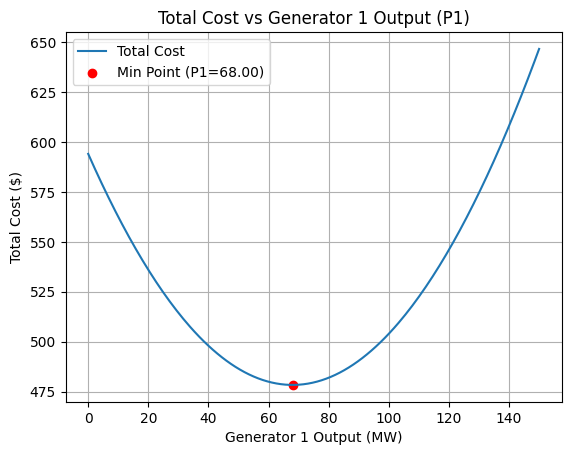

In [4]:
#--- Graphical Approach ---
#creates a function so that we can plot total cost vs P1
C_func = sp.lambdify(P1, C_tot, "numpy")

#define the domain for P1
P1_vals = np.linspace(0, 150, 200)
#find corresponding cost values by using created function
C_vals = C_func(P1_vals)
plt.plot(P1_vals, C_vals, label="Total Cost")
plt.scatter(float(P1_opt), float(C_min), color='red', label=f"Min Point (P1={float(P1_opt):.2f})")
plt.title("Total Cost vs Generator 1 Output (P1)")
plt.xlabel("Generator 1 Output (MW)")
plt.ylabel("Total Cost ($)")
plt.grid(True)
plt.legend()
plt.show()


Status: optimal
Optimal Total Cost = $478.40
P1 = 68.00 MW
P2 = 12.00 MW


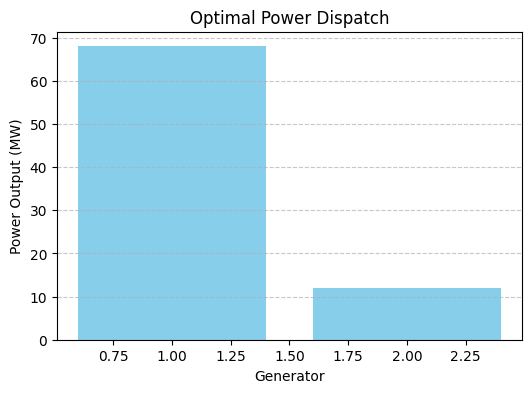

In [5]:
#---CVXPY Optimization for a Single Hour Classic EDP ---
# --- Parameters ---
#Generator quadratic, linear, and constant cost coefficents
a = np.array([10, 8])
b = np.array([5, 6])
c = np.array([0.01, 0.015])

#Generation limits min and max power output 
P_min = np.array([0, 0])
P_max = np.array([100, 100])

#Total load demand 
Pd = 80
 
#Transmission power loss 
Pl = 0


# --- Decision variable ---
m = len(a)
P = cp.Variable(m) #each element of power output is constrained to be non negative 


# --- Objective ---
#minimize total generation cost to meed load demand 
cost = cp.sum(a + cp.multiply(b, P) + cp.multiply(c, cp.square(P)))
objective = cp.Minimize(cost)


#--- Constraints ---
constraints = [
    cp.sum(P) == Pd + Pl,  #power balance 
    P >= P_min,            #minimum generation limits
    P <= P_max,           #maximum generation limits
    P >= 0
]

# --- Problem definition and solve ---
problem = cp.Problem(objective, constraints)
problem.solve()

# --- Results ---
print("Status:", problem.status)
print("Optimal Total Cost = $%.2f" % problem.value)
for i in range(m):
    print(f"P{i+1} = {P.value[i]:.2f} MW")

#--- Graphs ---
plt.figure(figsize=(6, 4))
plt.bar(range(1, m+1), P.value, color='skyblue')
plt.xlabel('Generator')
plt.ylabel('Power Output (MW)')
plt.title('Optimal Power Dispatch')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Status: optimal
Optimal Total Cost = $10765.90
Hour 1: P1 = 50.00 MW, P2 = 0.00 MW
Hour 2: P1 = 53.00 MW, P2 = 2.00 MW
Hour 3: P1 = 56.00 MW, P2 = 4.00 MW
Hour 4: P1 = 59.00 MW, P2 = 6.00 MW
Hour 5: P1 = 62.00 MW, P2 = 8.00 MW
Hour 6: P1 = 65.00 MW, P2 = 10.00 MW
Hour 7: P1 = 68.00 MW, P2 = 12.00 MW
Hour 8: P1 = 71.00 MW, P2 = 14.00 MW
Hour 9: P1 = 74.00 MW, P2 = 16.00 MW
Hour 10: P1 = 77.00 MW, P2 = 18.00 MW
Hour 11: P1 = 80.00 MW, P2 = 20.00 MW
Hour 12: P1 = 83.00 MW, P2 = 22.00 MW
Hour 13: P1 = 80.00 MW, P2 = 20.00 MW
Hour 14: P1 = 77.00 MW, P2 = 18.00 MW
Hour 15: P1 = 74.00 MW, P2 = 16.00 MW
Hour 16: P1 = 71.00 MW, P2 = 14.00 MW
Hour 17: P1 = 68.00 MW, P2 = 12.00 MW
Hour 18: P1 = 65.00 MW, P2 = 10.00 MW
Hour 19: P1 = 62.00 MW, P2 = 8.00 MW
Hour 20: P1 = 59.00 MW, P2 = 6.00 MW
Hour 21: P1 = 56.00 MW, P2 = 4.00 MW
Hour 22: P1 = 53.00 MW, P2 = 2.00 MW
Hour 23: P1 = 50.00 MW, P2 = 0.00 MW
Hour 24: P1 = 45.00 MW, P2 = 0.00 MW


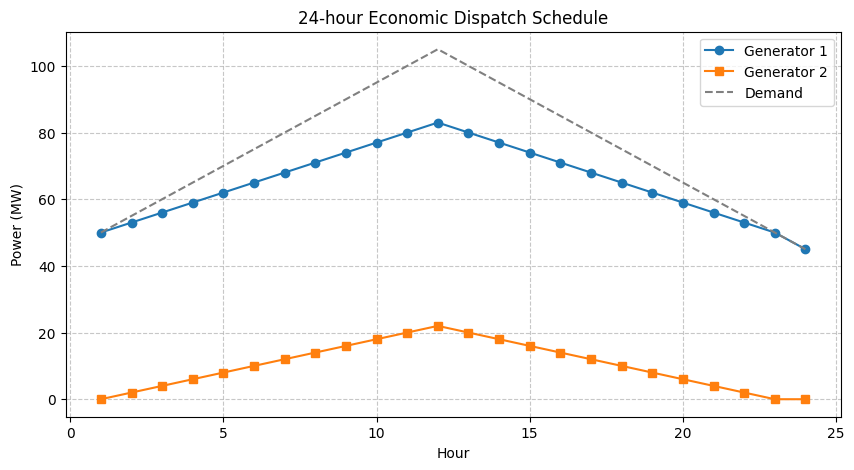

In [ ]:
#---CVXPY Optimization for a Multi Hour(24) Classic EDP ---
hours = 24
generators = 2

#Generator quadratic, linear, and constant cost coefficents
a = np.array([[10, 8]] * hours)
b = np.array([[5, 6]] * hours)
c = np.array([[0.01, 0.015]] * hours)

#Generation limits min and max power output
P_min = np.array([[0, 0]] * hours)
P_max = np.array([[100, 100]] * hours)

#Total load demand for 24 hours (example values) to represent peak and off-peak hours
Pd = np.array([50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105,
               100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45])

# Transmission losses (neglected)
Pl = 0

# Decision variable, power output matrix for 24 hours and 2 generators
P = cp.Variable((hours, generators))


cost = cp.sum(a + cp.multiply(b, P) + cp.multiply(c, cp.square(P)))
objective = cp.Minimize(cost)

constraints = []

for t in range(hours):
    constraints += [
        cp.sum(P[t, :]) == Pd[t] + Pl,   # Power balance each hour
        P[t, :] >= P_min[t, :],          # Min limits
        P[t, :] <= P_max[t, :],          # Max limits
        P[t, :] >= 0                     # Non-negative
    ]

problem = cp.Problem(objective, constraints)
problem.solve()

print("Status:", problem.status)
print("Optimal Total Cost = $%.2f" % problem.value)

for t in range(hours):
    print(f"Hour {t+1}: P1 = {P.value[t,0]:.2f} MW, P2 = {P.value[t,1]:.2f} MW")

plt.figure(figsize=(10, 5))
plt.plot(range(1, hours+1), P.value[:,0], label='Generator 1', marker='o')
plt.plot(range(1, hours+1), P.value[:,1], label='Generator 2', marker='s')
plt.plot(range(1, hours+1), Pd, label='Demand', linestyle='--', color='gray')
plt.xlabel('Hour')
plt.ylabel('Power (MW)')
plt.title('24-hour Economic Dispatch Schedule')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Status: optimal
Optimal Total Cost = $10653.61
Hour 1: P1 = 48.22 MW, P2 = 0.00 MW, Pch = 3.22 MW, Pdis = 0.00 MW, SoC = 53.06 MWh
Hour 2: P1 = 48.22 MW, P2 = 0.00 MW, Pch = 8.22 MW, Pdis = 0.00 MW, SoC = 60.87 MWh
Hour 3: P1 = 48.22 MW, P2 = 0.00 MW, Pch = 10.22 MW, Pdis = 0.00 MW, SoC = 70.57 MWh
Hour 4: P1 = 48.22 MW, P2 = 0.00 MW, Pch = 11.22 MW, Pdis = 0.00 MW, SoC = 81.23 MWh
Hour 5: P1 = 48.22 MW, P2 = 0.00 MW, Pch = 8.22 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 6: P1 = 50.00 MW, P2 = 0.00 MW, Pch = 0.00 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 7: P1 = 56.00 MW, P2 = 4.00 MW, Pch = 0.00 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 8: P1 = 62.00 MW, P2 = 8.00 MW, Pch = 0.00 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 9: P1 = 68.00 MW, P2 = 12.00 MW, Pch = 0.00 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 10: P1 = 71.00 MW, P2 = 14.00 MW, Pch = 0.00 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 11: P1 = 74.00 MW, P2 = 16.00 MW, Pch = 0.00 MW, Pdis = 0.00 MW, SoC = 89.04 MWh
Hour 12: P1 = 77.00 MW

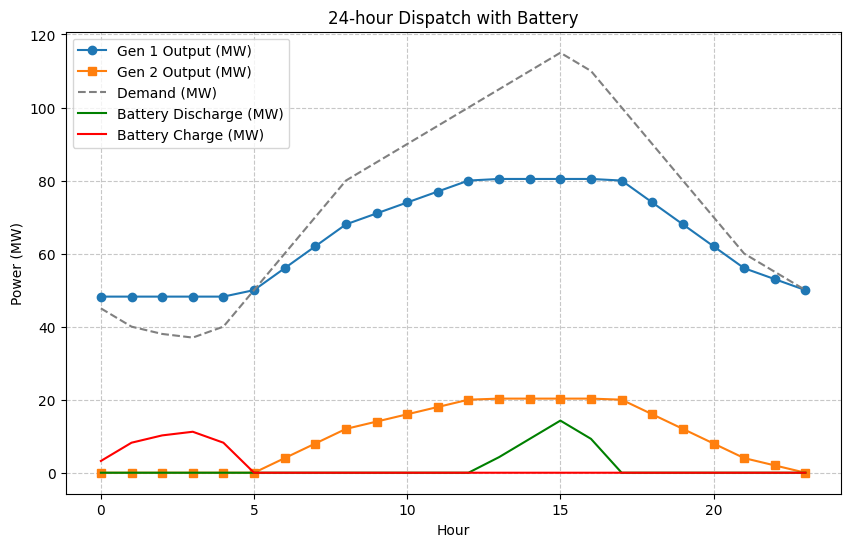

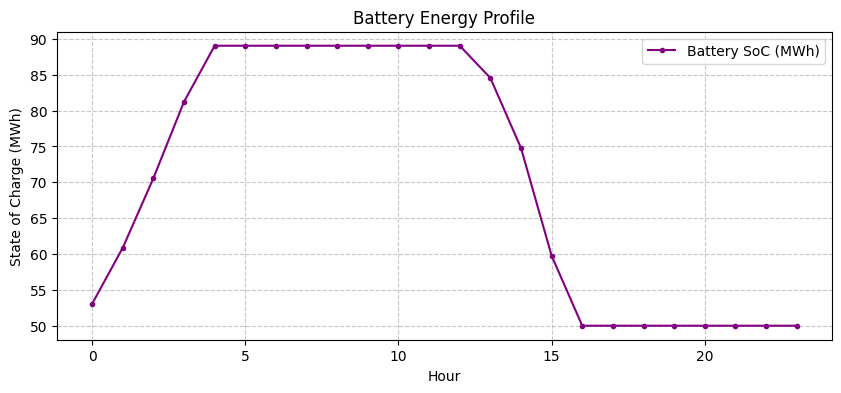

In [ ]:
#---CVXPY Optimization for a Multi Hour(24) Classic EDP with Battery Storage ---

# Parameters 
hours = 24
generators = 2

# Generator cost coefficients
a = np.array([[10, 8]] * hours)
b = np.array([[5, 6]] * hours)
c = np.array([[0.01, 0.015]] * hours)

# Generation limits
P_min = np.array([[0, 0]] * hours)
P_max = np.array([[100, 100]] * hours)

# Hourly demand (MW)
Pd = np.array([
    45, 40, 38, 37, 40, 50, 60, 70, 80, 85, 90, 95,
    100, 105, 110, 115, 110, 100, 90, 80, 70, 60, 55, 50
])

# Battery parameters 
E_max = 100     # MWh
E_min = 0       # MWh
P_ch_max = 30   # MW
P_dis_max = 30  # MW
eta_ch = 0.95   # charging efficiency
eta_dis = 0.95  # discharging efficiency
E0 = 50         # initial SoC (MWh)

# Decision variables 
P = cp.Variable((hours, generators))     # generator outputs
P_ch = cp.Variable(hours, nonneg=True)   # battery charge power
P_dis = cp.Variable(hours, nonneg=True)  # battery discharge power
E = cp.Variable(hours + 1)               # battery state of charge

# Objective function
cost = cp.sum(a + cp.multiply(b, P) + cp.multiply(c, cp.square(P)))
objective = cp.Minimize(cost)

# Constraints
constraints = []

# Initial state of charge
constraints += [E[0] == E0]

for t in range(hours):
    # Power balance
    constraints += [
        cp.sum(P[t, :]) + P_dis[t] == Pd[t] + P_ch[t],
        P[t, :] >= P_min[t, :],
        P[t, :] <= P_max[t, :],
    ]
    
    # Battery dynamics
    constraints += [
        E[t+1] == E[t] + eta_ch * P_ch[t] - (1/eta_dis) * P_dis[t],
        E[t+1] >= E_min,
        E[t+1] <= E_max,
        P_ch[t] <= P_ch_max,
        P_dis[t] <= P_dis_max,
    ]

# End SoC same as start SoC 
constraints += [E[-1] == E0]

problem = cp.Problem(objective, constraints)
problem.solve()

# Results
print("Status:", problem.status)
print("Optimal Total Cost = $%.2f" % problem.value)

for t in range(hours):
    print(f"Hour {t+1}: P1 = {P.value[t,0]:.2f} MW, P2 = {P.value[t,1]:.2f} MW, "
          f"Pch = {P_ch.value[t]:.2f} MW, Pdis = {P_dis.value[t]:.2f} MW, SoC = {E.value[t+1]:.2f} MWh")

# Plot
plt.figure(figsize=(10,6))
plt.plot(P.value[:,0], label="Gen 1 Output (MW)", marker='o')
plt.plot(P.value[:,1], label="Gen 2 Output (MW)", marker='s')
plt.plot(Pd, label="Demand (MW)", linestyle='--', color='gray')
plt.plot(P_dis.value, label="Battery Discharge (MW)", color='green')
plt.plot(P_ch.value, label="Battery Charge (MW)", color='red')
plt.xlabel("Hour")
plt.ylabel("Power (MW)")
plt.title("24-hour Dispatch with Battery")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# SoC curve
plt.figure(figsize=(10,4))
plt.plot(E.value[1:], label="Battery SoC (MWh)", color='purple', marker='.')
plt.xlabel("Hour")
plt.ylabel("State of Charge (MWh)")
plt.title("Battery Energy Profile")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
#---CVXPY Optimization for a Multi Hour(24) Classic EDP with Data from UCSD Microgrid for demand (Center Hall)
